# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

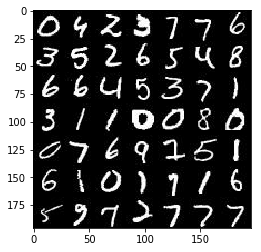

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

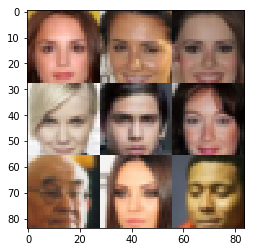

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # 14 * 14 * 128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 * 7 * 256
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4 * 4 * 512

        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4 * 4 * 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 * 7 * 256   
        
        x3 = tf.layers.conv2d_transpose(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # 14 * 14 * 512
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')

        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, 
        labels=tf.ones_like(d_model_real)
    ))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.zeros_like(d_model_fake)
    ))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.ones_like(d_model_fake)
    ))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    saver = tf.train.Saver()
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.6619... Generator Loss: 0.0811
Epoch 1/2... Discriminator Loss: 2.2772... Generator Loss: 0.1677
Epoch 1/2... Discriminator Loss: 0.2399... Generator Loss: 2.1488
Epoch 1/2... Discriminator Loss: 3.6414... Generator Loss: 19.7358
Epoch 1/2... Discriminator Loss: 0.2869... Generator Loss: 1.6569
Epoch 1/2... Discriminator Loss: 0.1838... Generator Loss: 4.0595
Epoch 1/2... Discriminator Loss: 3.1663... Generator Loss: 4.9117
Epoch 1/2... Discriminator Loss: 0.3266... Generator Loss: 2.6825
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.6261


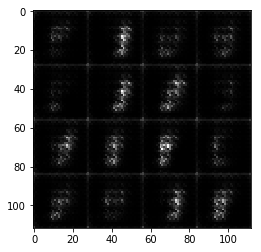

Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 1.4292
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.9920
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 2.7499
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.7573... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.0528
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 1.7458
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 0.9595


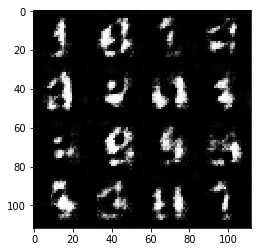

Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.6664
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 1.5391
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.5475
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.5168... Generator Loss: 0.3657
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 1.2707
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.3549


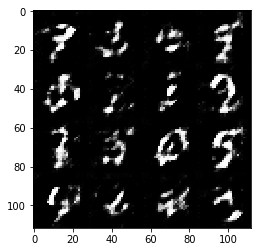

Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 0.9796... Generator Loss: 0.7882


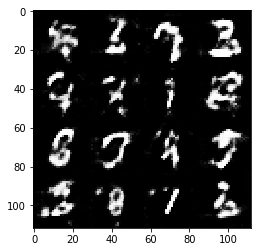

Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.5498
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.4560
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.4935
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 0.7028


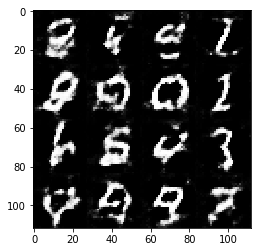

Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 1.0737
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 1.3013
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.6990


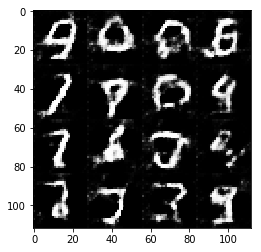

Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.4243
Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 0.4974
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 1.5142
Epoch 1/2... Discriminator Loss: 1.0752... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 1.7063


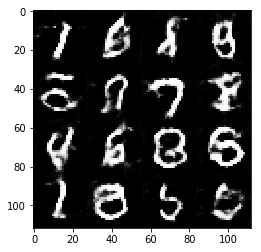

Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.5361
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.8079


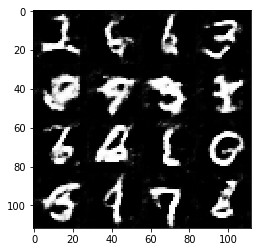

Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 1.3275
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 1.6247... Generator Loss: 2.3255
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 1.2040
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 2.3574
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.8932


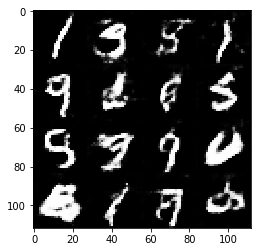

Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 1.4412
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 2.1294
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 0.9307


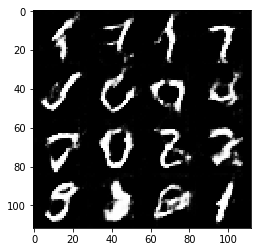

Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 0.8950... Generator Loss: 1.1740
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 1.8216... Generator Loss: 2.1625
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.4470
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.4142
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.2806


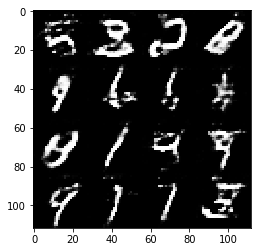

Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.4639
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 0.8531
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 2.0803
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.4692


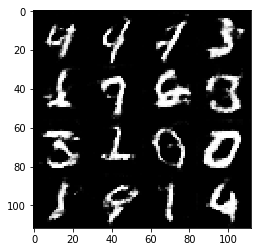

Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.4026
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.4106
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 0.9834


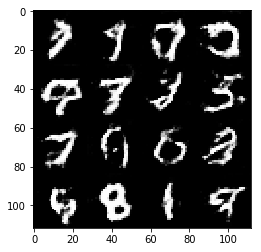

Epoch 2/2... Discriminator Loss: 0.8899... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 2.7475... Generator Loss: 0.1226
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 0.8278... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 1.8492
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 2.0086
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 2.3667


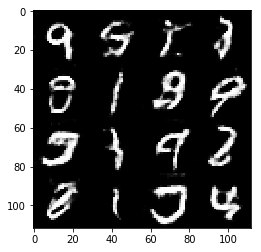

Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.1358
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.3987
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.7778


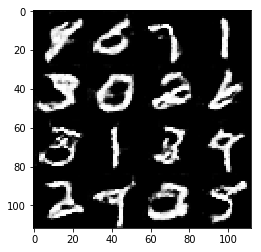

Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.7545... Generator Loss: 0.2904
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.4346
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.3996
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.6366
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 2.0234... Generator Loss: 0.2605


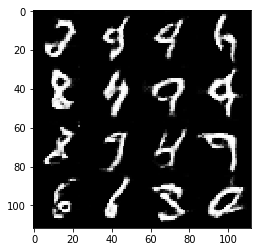

Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 0.6705... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 0.9027... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.8320... Generator Loss: 0.3942
Epoch 2/2... Discriminator Loss: 1.7692... Generator Loss: 0.3583
Epoch 2/2... Discriminator Loss: 0.4693... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 2.0739


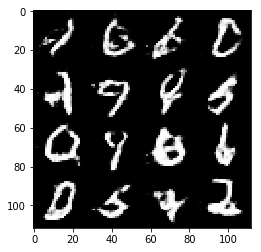

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.2099
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 3.1142
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.3785
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 0.5897... Generator Loss: 1.4909
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 2.9631
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 1.3287
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.6126


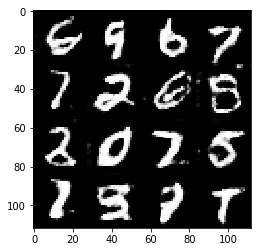

Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 0.5239... Generator Loss: 1.1954
Epoch 2/2... Discriminator Loss: 2.3054... Generator Loss: 0.1873
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.8095
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 1.2441
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.3184


In [17]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 2.7885... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 4.4863
Epoch 1/1... Discriminator Loss: 3.0878... Generator Loss: 2.7639
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.8975
Epoch 1/1... Discriminator Loss: 0.2890... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 3.8917
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 0.2403... Generator Loss: 3.9555


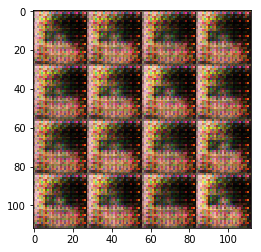

Epoch 1/1... Discriminator Loss: 0.1420... Generator Loss: 3.2148
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8103... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.9741
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 3.6317
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 2.3421
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 2.2821
Epoch 1/1... Discriminator Loss: 1.9184... Generator Loss: 5.6697


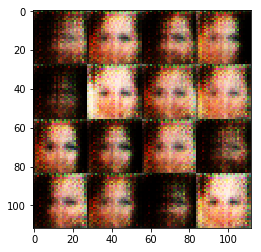

Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 4.0308
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 3.4010
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 2.8591
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 5.8539
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.3921


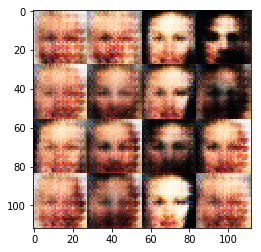

Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.3296
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 4.2215
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.2372
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 2.2326
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 3.5342
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.9846
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.2142
Epoch 1/1... Discriminator Loss: 0.2319... Generator Loss: 2.9654


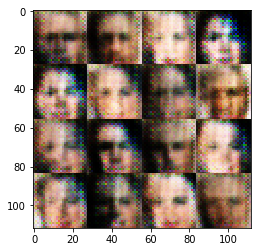

Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.6977
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 3.1248
Epoch 1/1... Discriminator Loss: 2.0632... Generator Loss: 0.2332
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 5.5740
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 2.4048
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.0597


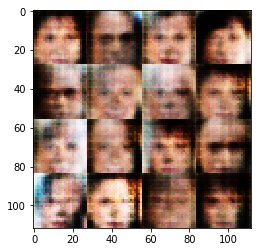

Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 2.4689
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.8972
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 3.2309
Epoch 1/1... Discriminator Loss: 1.9837... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 6.5460
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 4.7745


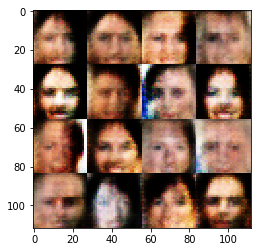

Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 3.7619
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.3183... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.1280... Generator Loss: 4.0851
Epoch 1/1... Discriminator Loss: 0.0971... Generator Loss: 3.1599
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 2.1272
Epoch 1/1... Discriminator Loss: 0.1343... Generator Loss: 3.0516
Epoch 1/1... Discriminator Loss: 3.2403... Generator Loss: 3.2752
Epoch 1/1... Discriminator Loss: 0.2491... Generator Loss: 2.8296
Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 2.2360


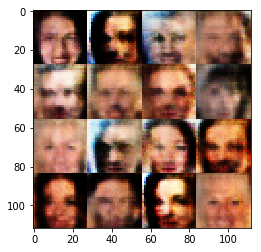

Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 2.1138
Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 5.4543
Epoch 1/1... Discriminator Loss: 0.0706... Generator Loss: 7.2247
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 2.2860
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 3.3310
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 2.1060
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 4.7950
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 4.9236


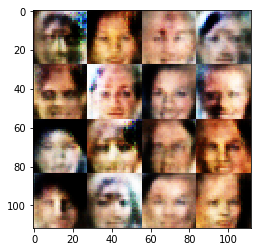

Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 8.0882
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.1387... Generator Loss: 6.5971
Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 4.5162
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 3.9077
Epoch 1/1... Discriminator Loss: 0.0934... Generator Loss: 6.6370
Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 2.9624
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 5.0375
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 3.7129


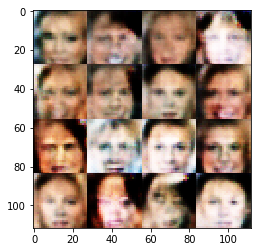

Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 2.6934
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 5.3777
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 5.3535
Epoch 1/1... Discriminator Loss: 0.0912... Generator Loss: 3.3015
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 5.2548
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 3.9584
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.7040


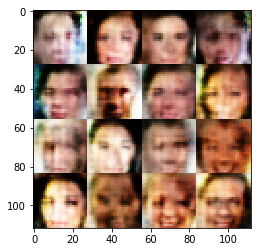

Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 3.6141
Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 3.7134
Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 1.7861
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.4879


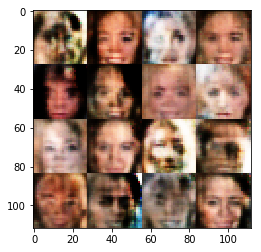

Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 3.1944
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 3.3164
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 0.0839... Generator Loss: 3.9283
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 2.6054
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 3.1505
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.4691
Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 1.6598


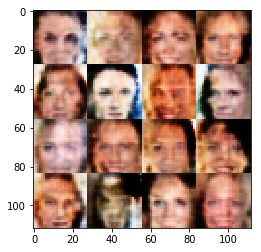

Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 2.0019
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.5250
Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 3.6058
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 5.2462
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 3.7289
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 6.7430
Epoch 1/1... Discriminator Loss: 0.2854... Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.1068... Generator Loss: 3.6609


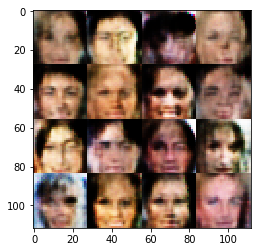

Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 5.3009
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 5.4162
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 0.1277... Generator Loss: 4.6950
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 3.5251
Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 1.9595
Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 2.2589
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 4.9897
Epoch 1/1... Discriminator Loss: 0.1404... Generator Loss: 4.7693


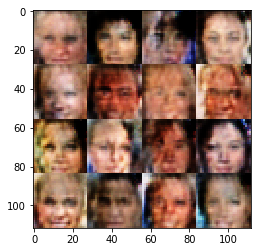

Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 4.5503
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 7.4336
Epoch 1/1... Discriminator Loss: 0.3150... Generator Loss: 6.7997
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.2073... Generator Loss: 2.2527
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 4.4180
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 3.4948
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 0.7896


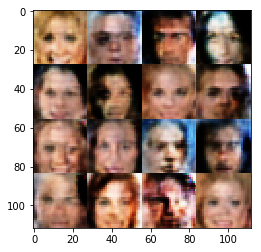

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 6.6379
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.0231
Epoch 1/1... Discriminator Loss: 0.2188... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 2.4233
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 2.9680
Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 3.4910
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 8.5574
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 3.8572
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 0.7745


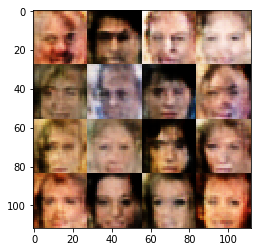

Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 2.5448
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 4.1877
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 3.7756
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 5.0163
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 5.2953
Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 2.8864


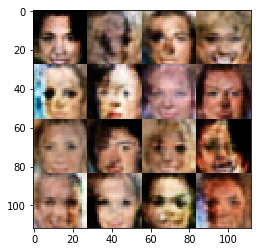

Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.3294
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 4.4607
Epoch 1/1... Discriminator Loss: 0.0467... Generator Loss: 3.7069
Epoch 1/1... Discriminator Loss: 2.3528... Generator Loss: 2.0374
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 5.6111
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 1.5382


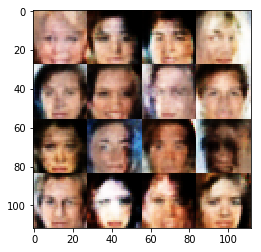

Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 2.6178
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 4.4481
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 3.8058
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 2.8163
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 3.4637
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 1.4302
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.6583


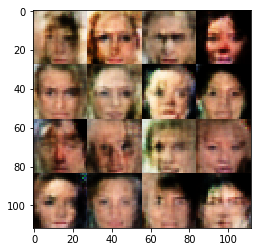

Epoch 1/1... Discriminator Loss: 0.1741... Generator Loss: 2.7284
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 4.7888
Epoch 1/1... Discriminator Loss: 0.1621... Generator Loss: 2.9616
Epoch 1/1... Discriminator Loss: 0.3250... Generator Loss: 1.7199
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 4.6710
Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 4.6806
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 3.4381
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 5.1194
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 4.6821


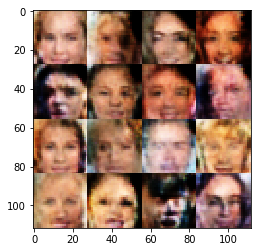

Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 6.1308
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.5883
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.2373
Epoch 1/1... Discriminator Loss: 2.3070... Generator Loss: 0.2108
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.4835
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 2.9709
Epoch 1/1... Discriminator Loss: 0.3147... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 3.9088


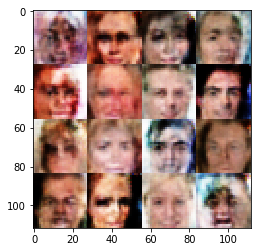

Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 1.8072
Epoch 1/1... Discriminator Loss: 0.1348... Generator Loss: 2.7896
Epoch 1/1... Discriminator Loss: 1.8413... Generator Loss: 5.8839
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 2.9557
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 2.6087
Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 4.1034
Epoch 1/1... Discriminator Loss: 0.1245... Generator Loss: 2.9598
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 3.0733


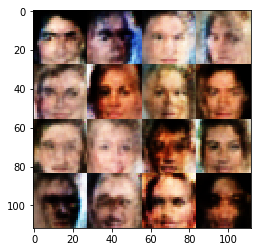

Epoch 1/1... Discriminator Loss: 0.1128... Generator Loss: 2.8225
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 4.3035
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 6.2685
Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 5.5689
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 3.0188
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 3.2772
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 3.9545
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 4.7361
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 8.1703
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 1.5645


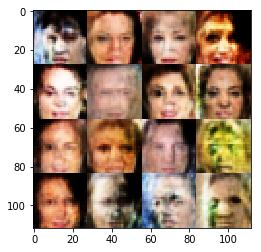

Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 2.6725
Epoch 1/1... Discriminator Loss: 0.1996... Generator Loss: 2.4663
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.4692
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 2.3510
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 3.1675
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 1.7844
Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 2.6521
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 5.9754


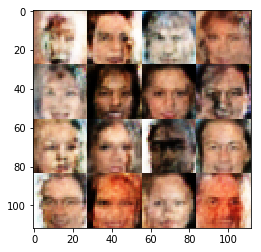

Epoch 1/1... Discriminator Loss: 0.0388... Generator Loss: 5.7684
Epoch 1/1... Discriminator Loss: 0.2380... Generator Loss: 1.8688
Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 2.0388
Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 5.0613
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 4.7882
Epoch 1/1... Discriminator Loss: 0.0721... Generator Loss: 4.0526
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 2.7914
Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 5.2376


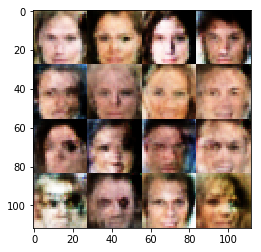

Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 4.3234
Epoch 1/1... Discriminator Loss: 1.8925... Generator Loss: 5.3330
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.7812
Epoch 1/1... Discriminator Loss: 0.2717... Generator Loss: 3.4198
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 4.5614
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 4.3763
Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 2.4358
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 3.4078


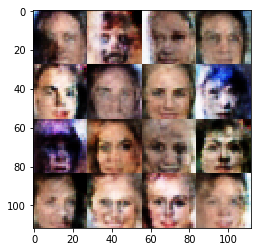

Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.6401
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 2.7931
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 3.7116
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 3.8951
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 2.1274
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 4.1561
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 4.4849
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 4.4508
Epoch 1/1... Discriminator Loss: 0.0413... Generator Loss: 4.8840


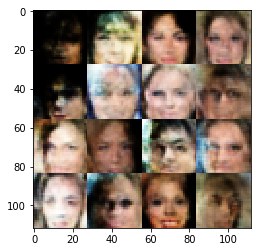

Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 5.0336
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 1.8398
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 4.9770
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 5.8627
Epoch 1/1... Discriminator Loss: 0.0853... Generator Loss: 3.6493
Epoch 1/1... Discriminator Loss: 2.2555... Generator Loss: 3.8997
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 2.1895
Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 2.2415
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 5.0986


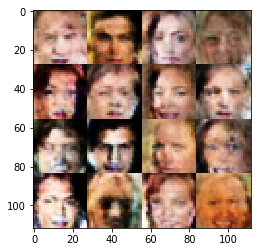

Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 4.2449
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 2.4503
Epoch 1/1... Discriminator Loss: 0.2638... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 2.6321
Epoch 1/1... Discriminator Loss: 0.1052... Generator Loss: 3.1796
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 4.2351
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 4.3541
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 4.5965
Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 1.8107


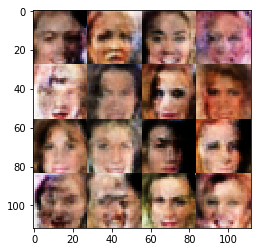

Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 2.2698
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 4.1618
Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 3.5560
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 6.7482
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 0.1957... Generator Loss: 2.7785
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 4.3587
Epoch 1/1... Discriminator Loss: 0.0966... Generator Loss: 5.1932
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 5.9160
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 2.4744


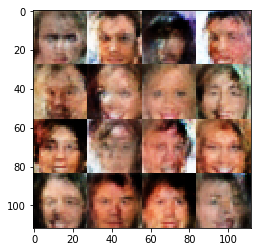

Epoch 1/1... Discriminator Loss: 3.5562... Generator Loss: 0.0416
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 2.2349... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.1684... Generator Loss: 2.8819
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 2.6178
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 3.1912
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.1111... Generator Loss: 6.0330


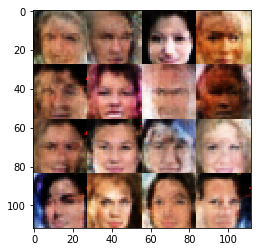

Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 3.6603
Epoch 1/1... Discriminator Loss: 0.0684... Generator Loss: 4.8369
Epoch 1/1... Discriminator Loss: 0.1143... Generator Loss: 2.6265
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 2.8481
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 5.1224
Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 5.8375


In [18]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.